In [11]:
import pandas as pd
import numpy as np
import time
import json
from typing import Iterable, Dict, Any, List, Optional
import requests
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
import requests

def _props_dict(item):
    props = {}
    plist = (item.get("propertyConceptList") or {}).get("propertyConcept") or []
    for p in plist:
        k = (p.get("propName") or "").strip()
        v = (p.get("propValue") or "").strip()
        if k:
            props[k.upper()] = v
    return props

def _first_match(props, *keys_or_contains):
    for key in keys_or_contains:
        if key in props:
            return props[key]
    for key in props:
        for needle in keys_or_contains:
            if needle in key:
                return props[key]
    return None

def _rxnorm_names_from_rxcui(rxcui):
    base = "https://rxnav.nlm.nih.gov/REST"
    url = f"{base}/rxcui/{rxcui}/allProperties.json"
    resp = requests.get(url, params={"prop": "names"}, timeout=10)
    resp.raise_for_status()
    data = resp.json() or {}
    props = (data.get("propConceptGroup") or {}).get("propConcept") or []
    names = [(p.get("propName"), p.get("propValue")) for p in props]

    brand = None
    for code, val in names:
        if (code or "").upper() in ("BN", "SBD", "SBDF", "SBDG") and val:
            brand = val
            break

    generic = None
    for code, val in names:
        if (code or "").upper() in ("IN", "SCD", "SCDF", "SCDC") and val:
            generic = val
            break

    if generic is None:
        url2 = f"{base}/rxcui/{rxcui}/property.json"
        r2 = requests.get(url2, params={"propName": "RxNorm Name"}, timeout=10)
        if r2.ok:
            dd = r2.json() or {}
            generic = (dd.get("propConceptGroup") or {}).get("propConcept", [{}])[0].get("propValue")

    return brand, generic

def get_names_for_ndc(ndc_code, ndcstatus="ALL"):
    """
    Returns a dict with:
      - ndc11
      - brand_name
      - product_type
      - generic_name
      - labeler
      - rxcui
    Uses RxCUI fallbacks to fill brand/generic when missing in NDC properties.
    """
    ndc_url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    r = requests.get(ndc_url, params={"id": ndc_code, "ndcstatus": ndcstatus}, timeout=10)
    r.raise_for_status()
    data = r.json() or {}
    items = (data.get("ndcPropertyList") or {}).get("ndcProperty") or []
    if not items:
        return {
            "ndc11": None,
            "brand_name": None,
            "product_type": None,
            "generic_name": None,
            "labeler": None,
            "rxcui": None,
        }

    # pick richest item (prefer one with explicit proprietary/nonproprietary if present)
    best = None
    for it in items:
        props = _props_dict(it)
        if "PROPRIETARYNAME" in props or "NONPROPRIETARYNAME" in props:
            best = it
            break
    if best is None:
        best = items[0]

    props = _props_dict(best)
    rxcui = best.get("rxcui")
    ndc11 = best.get("ndcItem")  # RxNav’s NDC11 field

    # direct reads
    brand = _first_match(props, "PROPRIETARYNAME", "PROPRIETARY NAME", "PROPRIETARY")
    generic = _first_match(props, "NONPROPRIETARYNAME", "NONPROPRIETARY NAME", "NONPROPRIETARY")
    product_type = _first_match(props, "PRODUCTTYPENAME", "PRODUCT TYPE")
    labeler = _first_match(props, "LABELER", "LABELERNAME", "LABELER NAME")

    # fallbacks via RxCUI
    if (not brand or not generic) and rxcui:
        rx_brand, rx_generic = _rxnorm_names_from_rxcui(rxcui)
        brand = brand or rx_brand
        generic = generic or rx_generic

    return {
        "ndc11": ndc11,
        "brand_name": brand,
        "product_type": product_type,   # e.g., HUMAN PRESCRIPTION DRUG
        "generic_name": generic,
        "labeler": labeler,
        "rxcui": rxcui,
    }

# ---- Example usage
if __name__ == "__main__":
    summary = get_names_for_ndc("00003-0894", ndcstatus="ALL")

print("NDC11:", summary["ndc11"])
print("Brand name:", summary["brand_name"])
print("Product type:", summary["product_type"])
print("Generic name:", summary["generic_name"])
print("Labeler:", summary["labeler"])
print("RxCUI:", summary["rxcui"])


NDC11: 00003089421
Brand name: None
Product type: None
Generic name: apixaban 5 MG Oral Tablet [Eliquis]
Labeler: E.R. Squibb & Sons, L.L.C.
RxCUI: 1364447


The percentage given in the lines:     
- print(f"\nYear {year}: Comparison with 'XX' (relative to XX values):")

- print(f"Units Reimbursed - Total: {total_units:.3f} B | XX: {xx_units:.3f} B | % diff: {units_diff_pct:.2f}%")

- print(f"Number of Prescriptions - Total: {total_prescriptions:.3f} M | XX: {xx_prescriptions:.3f} M | % diff: {presc_diff_pct:.2f}%")

total_units:.3f B → how many billions of units you got by summing all the states.

xx_units:.3f B → how many billions of units are reported by Medicaid under 'XX'. This is, the national total that Medicaid gives directly

e.g: “When I add up all the states, I get 30.5 billion units.
Medicaid’s national number (XX) is 31.2 billion units.
My total is about 2.4% smaller than theirs.”

In [39]:

#Final function for drug utilization data processing

def preliminar(file_path):
    
    year = file_path[4:8]

    df = pd.read_csv(file_path,low_memory=False)
    required_cols = ['State', 'NDC', 'Units Reimbursed', 'Number of Prescriptions']
    existing = [c for c in required_cols if c in df.columns]
    if existing:
        before = len(df)
        df = df.dropna(subset=existing)
        dropped = before - len(df)
        print(f"\nYear {year}: Dropped {dropped} rows with NA in {existing}")
    else:
        print(f"Year {year}: Required columns missing, skip NA drop")

    print(f"Year {year}: Total rows after NA drop: {len(df)}")

    df_xx = df[df['State'] == 'XX']
    print(f"Year {year}: Rows with invalid state code 'XX': {len(df_xx)}")

    df = df[df['State'] != 'XX']
    print(f"Year {year}: Rows after removing invalid state code 'XX': {len(df)}")

    df['Units Reimbursed'] = pd.to_numeric(df['Units Reimbursed'], errors='coerce')/1e9
    df['Number of Prescriptions'] = pd.to_numeric(df['Number of Prescriptions'], errors='coerce')/1e6

    state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
    #print(f"\nYear {year}: State Summary:")

    total_units = state_summary['Units Reimbursed'].sum()
    total_prescriptions = state_summary['Number of Prescriptions'].sum()
    print(f"\nYear {year}: Total Units Reimbursed across all states: {total_units}")
    print(f"Year {year}: Total Number of Prescriptions across all states: {total_prescriptions}")

    top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Units Reimbursed:")
    print(top_states_units)

    top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)
    print(f"\nYear {year}: Top 10 States by Number of Prescriptions:")
    print(top_states_prescriptions)

    # 'XX' invalid state code analysis with proper scaling
    wp = df_xx[['State', 'Units Reimbursed', 'Number of Prescriptions']].copy()
    if not wp.empty:
        wp['Units Reimbursed'] = pd.to_numeric(wp['Units Reimbursed'], errors='coerce') / 1e9  # billions
        wp['Number of Prescriptions'] = pd.to_numeric(wp['Number of Prescriptions'], errors='coerce') / 1e6  # millions
        wp_summary = wp.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()
        print(f"\nYear {year}: Summary for rows with invalid state code 'XX' (scaled):")
        print(wp_summary)

        xx_units = wp_summary['Units Reimbursed'].iloc[0]
        xx_prescriptions = wp_summary['Number of Prescriptions'].iloc[0]

        units_diff_pct = ((total_units - xx_units) / xx_units * 100) if xx_units else float('nan')
        presc_diff_pct = ((total_prescriptions - xx_prescriptions) / xx_prescriptions * 100) if xx_prescriptions else float('nan')

        print(f"\nYear {year}: Comparison with 'XX' (relative to XX values):")
        print(f"Units Reimbursed - Total: {total_units:.3f} B | XX: {xx_units:.3f} B | % diff: {units_diff_pct:.2f}%")
        print(f"Number of Prescriptions - Total: {total_prescriptions:.3f} M | XX: {xx_prescriptions:.3f} M | % diff: {presc_diff_pct:.2f}%")
    else:
        print(f"\nYear {year}: No data available for state code 'XX'.")

    correlation = state_summary['Units Reimbursed'].corr(state_summary['Number of Prescriptions'])
    print(f"\nYear {year}: Correlation between 'Units Reimbursed' and 'Number of Prescriptions': {correlation:.2f}")

# Inputs for multiple years (datasets)
preliminar('SDUD2010.csv')
#preliminar('SDUD2011.csv')
#preliminar('SDUD2012.csv')
#preliminar('SDUD2013.csv')
#preliminar('SDUD2014.csv')
#preliminar('SDUD2015.csv')
#preliminar('SDUD2016.csv')
#preliminar('SDUD2017.csv')
#preliminar('SDUD2018.csv')
#preliminar('SDUD2019.csv')
#preliminar('SDUD2020.csv')
#preliminar('SDUD2021.csv')
#preliminar('SDUD2022.csv')
#preliminar('SDUD2023.csv')
#preliminar('SDUD2024.csv')



Year 2010: Dropped 1472418 rows with NA in ['State', 'NDC', 'Units Reimbursed', 'Number of Prescriptions']
Year 2010: Total rows after NA drop: 1708143
Year 2010: Rows with invalid state code 'XX': 152049
Year 2010: Rows after removing invalid state code 'XX': 1556094

Year 2010: Total Units Reimbursed across all states: 30.506286994211
Year 2010: Total Number of Prescriptions across all states: 481.946148

Year 2010: Top 10 States by Units Reimbursed:
       Units Reimbursed  Number of Prescriptions
State                                           
NY             3.317278                55.211247
CA             3.313082                47.209227
TX             2.746984                32.287650
IL             1.454374                24.845893
FL             1.407399                21.512189
OH             1.405427                23.499459
NC             1.130608                16.173637
IN             0.985172                12.146278
MI             0.961484                15.937696
PA 

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\874965885.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_units.index, y=top_states_units['Units Reimbursed'], palette='viridis')
C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\874965885.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states_prescriptions.index, y=top_states_prescriptions['Number of Prescriptions'], palette='cividis')


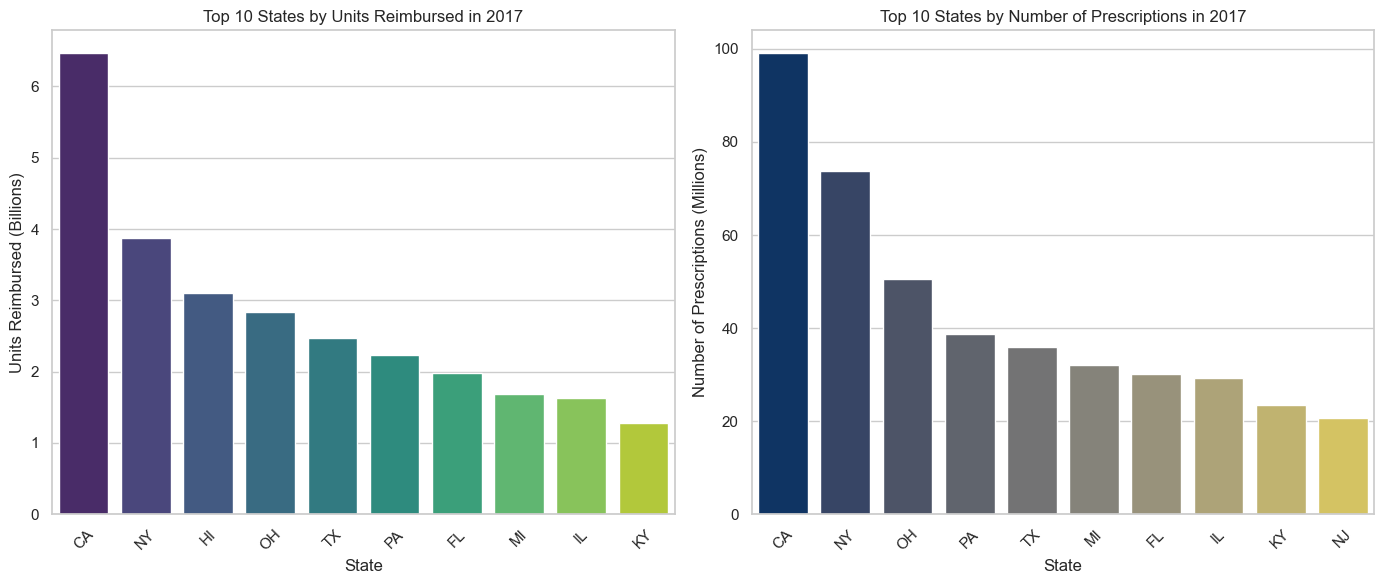

In [24]:
# plotting the top-ten states by category for a given year
def plot_top_ten_states(file_path):
    """
    Reads a CSV file, processes the drug utilization data, and plots the top ten states by Units Reimbursed and Number of Prescriptions.
    """
    year = file_path[4:8]

    df = pd.read_csv(file_path, low_memory=False)
    df = df[df['State'] != 'XX']
    state_summary = df.groupby('State')[['Units Reimbursed', 'Number of Prescriptions']].sum()

    U_factor=1e9 #Billions
    P_factor=1e6 #Millions

    state_summary['Units Reimbursed'] = state_summary['Units Reimbursed'] / U_factor
    state_summary['Number of Prescriptions'] = state_summary['Number of Prescriptions'] / P_factor

    top_states_units = state_summary.sort_values(by='Units Reimbursed', ascending=False).head(10)
    top_states_prescriptions = state_summary.sort_values(by='Number of Prescriptions', ascending=False).head(10)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(x=top_states_units.index, y=top_states_units['Units Reimbursed'], palette='viridis')
    plt.title(f'Top 10 States by Units Reimbursed in {year}')
    plt.xlabel('State')
    plt.ylabel('Units Reimbursed (Billions)')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.barplot(x=top_states_prescriptions.index, y=top_states_prescriptions['Number of Prescriptions'], palette='cividis')
    plt.title(f'Top 10 States by Number of Prescriptions in {year}')
    plt.xlabel('State')
    plt.ylabel('Number of Prescriptions (Millions)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage for plotting
plot_top_ten_states('SDUD2017.csv')

In [14]:
from collections import Counter
# Analyze top-N states by Units Reimbursed and Number of Prescriptions per year
top_n = 10
records = []

# Prefer already-built utilization dataframe (cell 5); fallback to CSVs
if 'util_df' in globals():
    years_iter = sorted(util_df['Year'].unique())
    def iter_year_data():
        for yr in years_iter:
            df_year = util_df[util_df['Year'] == yr].set_index('State')[['Units Reimbursed','Number of Prescriptions']]
            yield yr, df_year
else:
    if 'csv_files' in globals():
        file_paths = csv_files
    else:
        file_paths = [f"SDUD{y}.csv" for y in range(2010, 2025)]
    def iter_year_data():
        for fp in file_paths:
            yr = int(fp[4:8])
            df_year = pd.read_csv(fp)
            # Clean
            need = ['State','Units Reimbursed','Number of Prescriptions']
            have = [c for c in need if c in df_year.columns]
            if have:
                df_year = df_year.dropna(subset=have)
            if 'State' in df_year.columns:
                df_year = df_year[df_year['State'] != 'XX']
            df_year = (df_year
                       .groupby('State')[['Units Reimbursed','Number of Prescriptions']]
                       .sum())
            yield yr, df_year

for year, state_summary in iter_year_data():
    if state_summary.empty:
        continue

    # Top-N lists
    top_units = (state_summary
                 .sort_values('Units Reimbursed', ascending=False)
                 .head(top_n))
    top_presc = (state_summary
                 .sort_values('Number of Prescriptions', ascending=False)
                 .head(top_n))

    units_order = list(top_units.index)
    presc_order = list(top_presc.index)
    rank_units = {s: i+1 for i, s in enumerate(units_order)}
    rank_presc = {s: i+1 for i, s in enumerate(presc_order)}

    all_states = list(dict.fromkeys(units_order + presc_order))  # preserve order: units first then new from prescriptions

    print(f"\nYear {year}: Rank Comparison (Top {top_n})")
    print("State | Rank Units | Rank Prescriptions | Same Position | Appearance")
    for s in all_states:
        ru = rank_units.get(s)
        rp = rank_presc.get(s)
        if ru and rp:
            same = (ru == rp)
            appearance = "Both"
        elif ru and not rp:
            same = False
            appearance = "Units only"
        else:
            same = False
            appearance = "Prescriptions only"
        print(f"{s:>4}  | {str(ru or '-'):>10} | {str(rp or '-'):>18} | {str(same):>13} | {appearance}")

    # Store records
    for i, s in enumerate(units_order, start=1):
        records.append({'Year': year, 'Category': 'Units Reimbursed', 'Rank': i, 'State': s})
    for i, s in enumerate(presc_order, start=1):
        records.append({'Year': year, 'Category': 'Number of Prescriptions', 'Rank': i, 'State': s})

# Build DataFrame of all rankings
top_states_df = pd.DataFrame(records)

# Frequency counters across all years
top_states_counter_units = Counter(r['State'] for r in records if r['Category'] == 'Units Reimbursed')
top_states_counter_prescriptions = Counter(r['State'] for r in records if r['Category'] == 'Number of Prescriptions')

print("\nStates frequency in Top Units Reimbursed (across years):")
print(top_states_counter_units.most_common())

print("\nStates frequency in Top Number of Prescriptions (across years):")
print(top_states_counter_prescriptions.most_common())

# identify states that ever appeared only in one metric in a year
exclusive_records = []
for year in top_states_df['Year'].unique():
    u = set(top_states_df[(top_states_df.Year==year) & (top_states_df.Category=='Units Reimbursed')]['State'])
    p = set(top_states_df[(top_states_df.Year==year) & (top_states_df.Category=='Number of Prescriptions')]['State'])
    only_units = u - p
    only_presc = p - u
    for s in sorted(only_units):
        exclusive_records.append({'Year': year, 'State': s, 'Exclusive': 'Units'})
    for s in sorted(only_presc):
        exclusive_records.append({'Year': year, 'State': s, 'Exclusive': 'Prescriptions'})

exclusive_df = pd.DataFrame(exclusive_records).sort_values(['Year','Exclusive','State'])
print("\nStates appearing exclusively in one top-10 list per year:")
print(exclusive_df if not exclusive_df.empty else "None")


C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\2976837042.py:21: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_year = pd.read_csv(fp)



Year 2010: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  NY  |          1 |                  1 |          True | Both
  CA  |          2 |                  2 |          True | Both
  TX  |          3 |                  3 |          True | Both
  IL  |          4 |                  4 |          True | Both
  FL  |          5 |                  6 |         False | Both
  OH  |          6 |                  5 |         False | Both
  NC  |          7 |                  8 |         False | Both
  IN  |          8 |                  - |         False | Units only
  MI  |          9 |                  9 |          True | Both
  PA  |         10 |                  7 |         False | Both
  MO  |          - |                 10 |         False | Prescriptions only

Year 2011: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  2 |         False | Both
  NY  |     

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\2976837042.py:21: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_year = pd.read_csv(fp)



Year 2012: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  TN  |          1 |                  - |         False | Units only
  NY  |          2 |                  1 |         False | Both
  CA  |          3 |                  2 |         False | Both
  TX  |          4 |                  3 |         False | Both
  OH  |          5 |                  4 |         False | Both
  FL  |          6 |                  6 |          True | Both
  PA  |          7 |                  5 |         False | Both
  IL  |          8 |                  7 |         False | Both
  MI  |          9 |                  8 |         False | Both
  NC  |         10 |                  9 |         False | Both
  GA  |          - |                 10 |         False | Prescriptions only


C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\2976837042.py:21: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_year = pd.read_csv(fp)



Year 2013: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  NY  |          1 |                  1 |          True | Both
  CA  |          2 |                  2 |          True | Both
  TX  |          3 |                  3 |          True | Both
  FL  |          4 |                  5 |         False | Both
  OH  |          5 |                  4 |         False | Both
  PA  |          6 |                  6 |          True | Both
  MI  |          7 |                  7 |          True | Both
  GA  |          8 |                  9 |         False | Both
  NC  |          9 |                 10 |         False | Both
  AZ  |         10 |                  - |         False | Units only
  IL  |          - |                  8 |         False | Prescriptions only


C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\2976837042.py:21: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_year = pd.read_csv(fp)



Year 2014: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  1 |          True | Both
  NY  |          2 |                  2 |          True | Both
  TX  |          3 |                  3 |          True | Both
  FL  |          4 |                  5 |         False | Both
  OH  |          5 |                  4 |         False | Both
  PA  |          6 |                  6 |          True | Both
  MI  |          7 |                  7 |          True | Both
  NC  |          8 |                  9 |         False | Both
  IL  |          9 |                  8 |         False | Both
  GA  |         10 |                 10 |          True | Both

Year 2015: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  1 |          True | Both
  NY  |          2 |                  2 |          True | Both
  TX  |          3 |            

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\2976837042.py:21: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_year = pd.read_csv(fp)



Year 2017: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  1 |          True | Both
  NY  |          2 |                  2 |          True | Both
  HI  |          3 |                  - |         False | Units only
  OH  |          4 |                  3 |         False | Both
  TX  |          5 |                  5 |          True | Both
  PA  |          6 |                  4 |         False | Both
  FL  |          7 |                  7 |          True | Both
  MI  |          8 |                  6 |         False | Both
  IL  |          9 |                  8 |         False | Both
  KY  |         10 |                  9 |         False | Both
  NJ  |          - |                 10 |         False | Prescriptions only

Year 2018: Rank Comparison (Top 10)
State | Rank Units | Rank Prescriptions | Same Position | Appearance
  CA  |          1 |                  1 |          True | Both
  NY  |     

In [25]:
#Using population data (BOTH DATASETS)

# Load population data (2010-2019 and 2020-2024)
pop0_df = pd.read_excel("../Population/20102020_pop.xlsx", engine="openpyxl")
pop1_df = pd.read_excel("../Population/20202024_pop.xlsx", engine="openpyxl")


def _clean_pop(df):
    df = df.copy()
    df['Geographic Area'] = df['Geographic Area'].str.replace('.', '', regex=False).str.strip()
    return df

pop0_df = _clean_pop(pop0_df)
pop1_df = _clean_pop(pop1_df)

# Combine year columns horizontally by Geographic Area
pop_df = pop0_df.merge(pop1_df, on='Geographic Area', how='outer')

# Drop totally empty area rows
pop_df = pop_df[pop_df['Geographic Area'].notna()].reset_index(drop=True)

# Coerce numeric columns
for c in pop_df.columns:
    if c != 'Geographic Area':
        pop_df[c] = pd.to_numeric(pop_df[c], errors='coerce')

# Order columns: Geographic Area, then years (keeping B before final year where applicable)
def _col_key(c):
    if c == 'Geographic Area':
        return (0, 0, 0)
    sc = str(c)
    base = sc.rstrip('B')
    if base.isdigit():
        return (1, int(base), 0 if sc.endswith('B') else 1)
    return (2, sc, 0)

ordered_cols = ['Geographic Area'] + sorted([c for c in pop_df.columns if c != 'Geographic Area'], key=_col_key)
pop_df = pop_df[ordered_cols]

print(pop_df.head())

  Geographic Area       2010B        2010        2011        2012        2013  \
0         Alabama   4780118.0   4788095.0   4812576.0   4839947.0   4865253.0   
1          Alaska    710246.0    714015.0    722513.0    731106.0    738054.0   
2         Arizona   6392292.0   6401304.0   6443158.0   6501800.0   6555926.0   
3        Arkansas   2916029.0   2921546.0   2938773.0   2948793.0   2954563.0   
4      California  37254522.0  37322523.0  37651212.0  37971412.0  38292557.0   

         2014        2015        2016        2017        2018        2019  \
0   4887757.0   4909177.0   4931579.0   4953096.0   4977088.0   5003778.0   
1    737634.0    739120.0    743397.0    741937.0    737710.0    734820.0   
2   6629890.0   6705607.0   6793278.0   6872380.0   6964300.0   7067695.0   
3   2961050.0   2970210.0   2980475.0   2990702.0   2997195.0   3004206.0   
4  38637421.0  38966939.0  39223789.0  39424315.0  39535920.0  39547995.0   

        2020B        2020        2021        2022 

In [16]:
#Merging datasets
from pathlib import Path

# 1. Aggregate utilization per State-Year
def build_utilization_dataframe(file_paths):
    frames = []
    usecols = ['State','Units Reimbursed','Number of Prescriptions']
    for fp in file_paths:
        year = int(Path(fp).stem[-4:])  # assumes pattern SDUDYYYY.csv
        df = pd.read_csv(fp, usecols=usecols, low_memory=False)
        df = df[df['State'].ne('XX')]  # drop invalid
        state_summary = df.groupby('State', as_index=False).sum()
        state_summary['Year'] = year
        frames.append(state_summary)
    return pd.concat(frames, ignore_index=True)

csv_years = list(range(2010, 2025))  # adjust if more years available
csv_files = [f"SDUD{y}.csv" for y in csv_years]
util_df = build_utilization_dataframe(csv_files)

# 2. Reshape population data to long format (ensure pop_df already loaded earlier)
# CHANGED: coerce column name to str before isdigit() to avoid AttributeError on int columns; keep only 4-digit years
pop_year_cols = [c for c in pop_df.columns if str(c).isdigit() and len(str(c)) == 4]
pop_long = pop_df.melt(id_vars=['Geographic Area'], value_vars=pop_year_cols,
                       var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)

# 3. Map full state names to postal abbreviations
state_map = {
 'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
 'DE':'Delaware','DC':'District of Columbia','FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois',
 'IN':'Indiana','IA':'Iowa','KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts',
 'MI':'Michigan','MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
 'NJ':'New Jersey','NM':'New Mexico','NY':'New York','NC':'North Carolina','ND':'North Dakota','OH':'Ohio','OK':'Oklahoma','OR':'Oregon',
 'PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont',
 'VA':'Virginia','WA':'Washington','WV':'West Virginia','WI':'Wisconsin','WY':'Wyoming'
}
full_to_abbrev = {v:k for k,v in state_map.items()}
pop_long['State'] = pop_long['Geographic Area'].map(full_to_abbrev)
pop_long = pop_long.dropna(subset=['State'])

# 4. Keep only population years that exist in utilization
pop_long = pop_long[pop_long['Year'].isin(util_df['Year'].unique())]

# 5. Merge
merged = util_df.merge(pop_long[['State','Year','Population']], on=['State','Year'], how='left')

# 6. Reorder + add normalized columns
merged = merged[['State','Year','Population','Units Reimbursed','Number of Prescriptions']]

merged['N Prescriptions norm'] = merged['Number of Prescriptions'] / merged['Population']
merged['N Units reimbursed norm'] = merged['Units Reimbursed'] / merged['Population']

# 7. Inspect
print(merged.head())
print('\nShape:', merged.shape)

# Just checking
only2010 = merged[merged['Year']==2010]
onlyIN= merged[merged['State']=='IN']
#print(only2010)
print('\n2010 Shape:', only2010.shape)
print(onlyIN)
# 'merged' now contains the requested combined dataframe


  State  Year  Population  Units Reimbursed  Number of Prescriptions  \
0    AK  2010    714015.0      4.610507e+07                1006168.0   
1    AL  2010   4788095.0      4.821577e+08                8525050.0   
2    AR  2010   2921546.0      2.908855e+08                4788392.0   
3    AZ  2010   6401304.0      6.108745e+08               10514315.0   
4    CA  2010  37322523.0      3.313082e+09               47209227.0   

   N Prescriptions norm  N Units reimbursed norm  
0              1.409169                64.571570  
1              1.780468               100.699285  
2              1.638993                99.565613  
3              1.642527                95.429691  
4              1.264899                88.768972  

Shape: (767, 7)

2010 Shape: (51, 7)
    State  Year  Population  Units Reimbursed  Number of Prescriptions  \
15     IN  2010   6491385.0      9.851722e+08               12146278.0   
66     IN  2011   6521409.0      9.501631e+08               11688407.0   
1


Correlation between 'N Units reimbursed norm' and 'N Prescriptions norm': 0.49


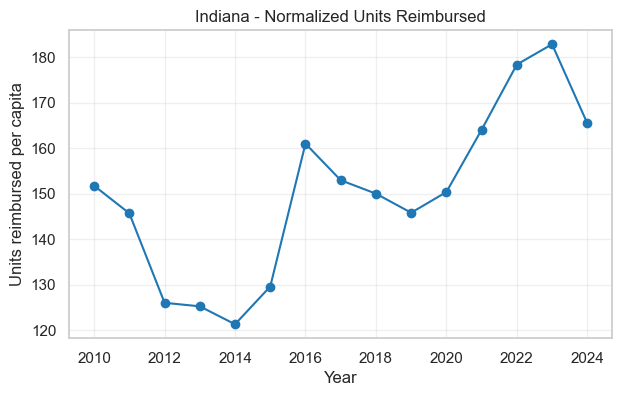

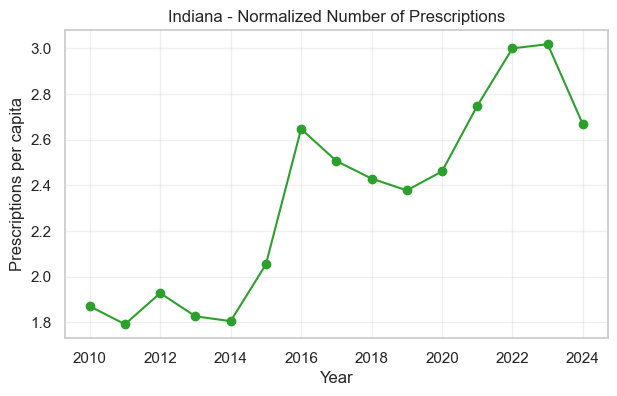

In [19]:
# look at correlations and patterns
corr_pop = merged['N Units reimbursed norm'].corr(merged['N Prescriptions norm'])
print(f"\nCorrelation between 'N Units reimbursed norm' and 'N Prescriptions norm': {corr_pop:.2f}")
# Filter data for Indiana
indiana_data = merged.loc[merged['State'] == 'IN'].sort_values('Year').dropna(
    subset=['N Units reimbursed norm', 'N Prescriptions norm']
)

# Line chart 1: Normalized Units Reimbursed
plt.figure(figsize=(7,4))
plt.plot(indiana_data['Year'], indiana_data['N Units reimbursed norm'], marker='o', color='tab:blue')
plt.title('Indiana - Normalized Units Reimbursed')
plt.xlabel('Year')
plt.ylabel('Units reimbursed per capita')
plt.grid(alpha=0.3)

# Line chart 2: Normalized Number of Prescriptions
plt.figure(figsize=(7,4))
plt.plot(indiana_data['Year'], indiana_data['N Prescriptions norm'], marker='o', color='tab:green')
plt.title('Indiana - Normalized Number of Prescriptions')
plt.xlabel('Year')
plt.ylabel('Prescriptions per capita')
plt.grid(alpha=0.3)

C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\1723075274.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x=col, y='State', ax=ax, palette=palette, orient='h')
C:\Users\lholguin\AppData\Local\Temp\1\ipykernel_1736\1723075274.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top, x=col, y='State', ax=ax, palette=palette, orient='h')


(<Figure size 700x500 with 1 Axes>,
 <Axes: title={'center': '2021 Top 10: Units reimbursed per capita'}, xlabel='Units reimbursed per capita', ylabel='State'>)

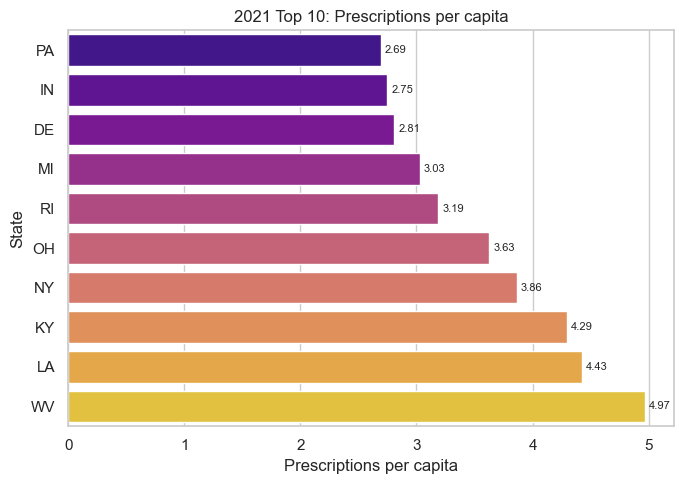

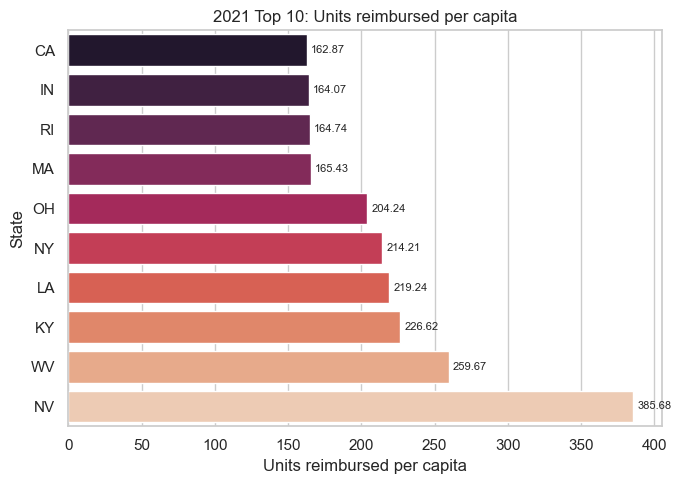

In [18]:
# Top-ten normalized plotting utilities (prescriptions & units)
# Trying to see if the top states coincide for both metrics and the past 

def _top_norm(year: int, col: str, n: int = 10):
    if 'merged' not in globals():
        raise RuntimeError("'merged' DataFrame not found. Run the merge cell first.")
    df_year = merged[merged['Year'] == year]
    if df_year.empty:
        raise ValueError(f"Year {year} not found in merged DataFrame.")
    return (df_year
            .nlargest(n, col)[['State', col]]
            .sort_values(col))

def plot_top_ten_prescriptions_norm(year: int, n: int = 10, figsize=(7,5), palette='plasma'):
    col = 'N Prescriptions norm'
    top = _top_norm(year, col, n)
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=top, x=col, y='State', ax=ax, palette=palette, orient='h')
    ax.set_title(f"{year} Top {n}: Prescriptions per capita")
    ax.set_xlabel('Prescriptions per capita')
    ax.set_ylabel('State')
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', padding=3, fontsize=8)
    plt.tight_layout()
    return fig, ax

def plot_top_ten_units_norm(year: int, n: int = 10, figsize=(7,5), palette='rocket'):
    col = 'N Units reimbursed norm'
    top = _top_norm(year, col, n)
    sns.set_theme(style='whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=top, x=col, y='State', ax=ax, palette=palette, orient='h')
    ax.set_title(f"{year} Top {n}: Units reimbursed per capita")
    ax.set_xlabel('Units reimbursed per capita')
    ax.set_ylabel('State')
    for c in ax.containers:
        ax.bar_label(c, fmt='%.2f', padding=3, fontsize=8)
    plt.tight_layout()
    return fig, ax

# Example usage (uncomment to run):
plot_top_ten_prescriptions_norm(2021)
plot_top_ten_units_norm(2021)
